In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from shapely.geometry import Point, Polygon

import yolo3_one_file_to_detect_them_all as yolo3
from keras.models import load_model

from datetime import datetime

%matplotlib inline

# 1. Court Detection

In [2]:
def init_court_capture(file_path, scaling_factor):
    
    cap = cv2.VideoCapture(file_path)
    ret, frame = cap.read()
    
    width = int(frame.shape[1] * scaling_factor)
    length = int(frame.shape[0] * scaling_factor)
    img = cv2.resize(frame, (width, length), interpolation=cv2.INTER_AREA)
    
    return img

In [3]:
def show_img(img, title, scaling_factor):
    
    width = int(img.shape[1] * scaling_factor)
    length = int(img.shape[0] * scaling_factor)
    img = cv2.resize(img, (width, length), interpolation=cv2.INTER_AREA)

    cv2.imshow(title, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [4]:
PATH = './data/downverse.com - Ma Long vs Fan Zhendong  Bank of Communications 2020 ITTF Finals (Final) trimmed.mp4'
scaling_factor = 1

In [7]:
img = init_court_capture(PATH, scaling_factor)
img_copy = img.copy()

show_img(img, 'original image', scaling_factor)

In [6]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

show_img(gray_img, 'grayscale image version', scaling_factor)

In [7]:
canny = cv2.Canny(gray_img, 10, 120, L2gradient=False)

show_img(canny, 'canny edges', scaling_factor)

In [9]:
ret, thresh = cv2.threshold(gray_img, thresh=127, maxval=255, type=cv2.THRESH_BINARY)
show_img(thresh, 'image threshold', scaling_factor)
_, contours, _ = cv2.findContours(image=thresh.copy(), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)

cv2.drawContours(img_copy, contours=contours, contourIdx=-1, color=(0,255,0), thickness=3)

show_img(img_copy, 'image contours', scaling_factor)

# findContours

In [10]:
copy_img = img.copy()

# Grayscale and binarize
gray_img = cv2.cvtColor(copy_img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray_img, 178, 255, cv2.THRESH_BINARY)

# Find contours 
_, contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

# Iterate through each contour and compute the bounding rectangle
for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(copy_img,(x,y),(x+w,y+h),(0,0,255),2)    
    cv2.imshow('Bounding Rectangle', copy_img)

cv2.waitKey(0) 
cv2.destroyAllWindows()

copy_img = img.copy()
    
# Iterate through each contour and compute the approx contour
for c in contours:
    # Calculate accuracy as a percent of the contour perimeter
    accuracy = 0.01 * cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, accuracy, True)
    cv2.drawContours(copy_img, [approx], 0, (0, 255, 0), 2)
    cv2.imshow('Approx Poly DP', copy_img)
    
cv2.waitKey(0)   
cv2.destroyAllWindows()

# Convex Hull

In [11]:
copy_img = img.copy()

cv2.imshow('Original Image', copy_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Threshold the image
ret, thresh = cv2.threshold(gray_img, 178, 255, cv2.THRESH_BINARY)

# Find contours 
_, contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
# Sort Contors by area and then remove the largest frame contour
n = len(contours) - 1
contours = sorted(contours, key=cv2.contourArea, reverse=False)[:n]

# Iterate through contours and draw the convex hull
for c in contours:
    hull = cv2.convexHull(c)
    cv2.drawContours(copy_img, [hull], 0, (0, 255, 0), 2)
    cv2.imshow('Convex Hull', copy_img)

cv2.waitKey(0)    
cv2.destroyAllWindows()

# Hough Lines

In [12]:
img_copy = img.copy()

# Grayscale and Canny Edges extracted
gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 80, apertureSize = 3)

# Run HoughLines using a rho accuracy of 1 pixel
# theta accuracy of np.pi / 180 which is 1 degree
# Our line threshold is set to 240 (number of points on line)
lines = cv2.HoughLines(edges, 1, np.pi / 180, 200, None, 0, 0)

# We iterate through each line and convert it to the format
# required by cv.lines (i.e. requiring end points)
for rho, theta in np.squeeze(lines):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(gray, (x1, y1), (x2, y2), (0, 255, 0), 2)

cv2.imshow('Hough Lines', gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [13]:
img_copy = img.copy()

gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 10, 50, apertureSize = 3)

# Again we use the same rho and theta accuracies
# However, we specific a minimum vote (pts along line) of 100
# and Min line length of 5 pixels and max gap between lines of 10 pixels
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, 5, 10)
print(lines.shape)

for x1, y1, x2, y2 in np.squeeze(lines):
    cv2.line(gray, (x1, y1), (x2, y2),(0, 255, 0), 3)

cv2.imshow('Probabilistic Hough Lines', gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

(272, 1, 4)


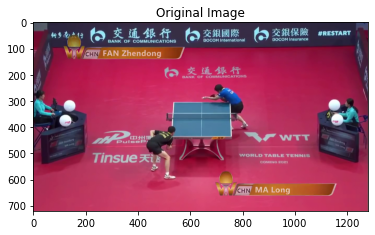

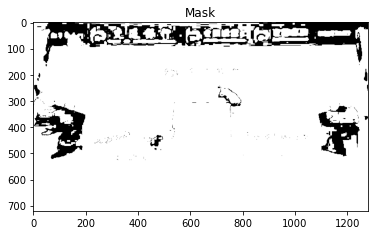

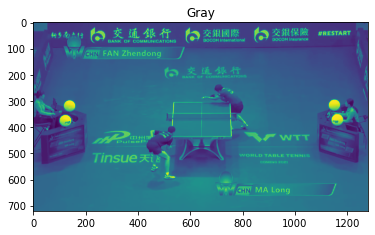

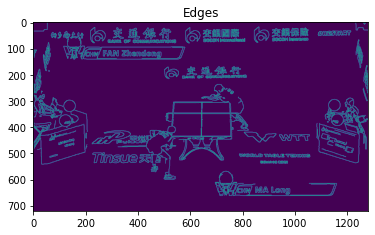

462
[[ 799  661 1134  661]]
[[262  95 527  95]]
[[204 141 555 141]]
[[531 434 755 434]]


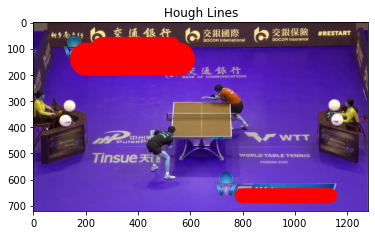

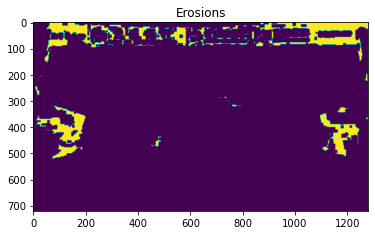

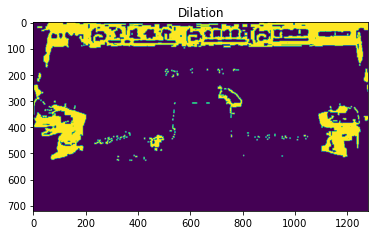

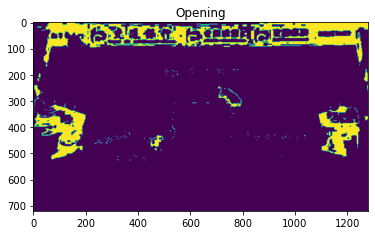

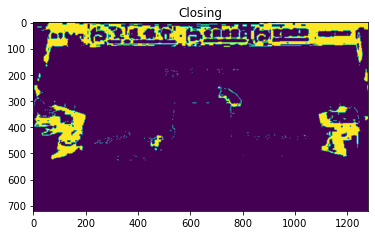

In [14]:
# USAGE
# python court_detection1.py --input input/kta_court.png
#
# author: Stephan Janssen
#

img_copy = img.copy()

# convert to HSV image
hsv_img = cv2.cvtColor(img_copy, cv2.COLOR_BGR2HSV)

# HARD CODED COURT COLOR :(
court_color = np.uint8([[[135,67,72]]])

hsv_court_color = cv2.cvtColor(court_color, cv2.COLOR_BGR2HSV)
hue = hsv_court_color[0][0][0]

# define range of blue color in HSV - Again HARD CODED! :(
lower_color = np.array([hue - 10,10,10])
upper_color = np.array([hue + 10,255,255])

# Threshold the HSV image to get only blue colors
mask = cv2.inRange(hsv_img, lower_color, upper_color)

# Bitwise-AND mask and original image
res = cv2.bitwise_and(img_copy, img_copy, mask=mask)

# Show original image
plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)) 
plt.title('Original Image') 
plt.show()

# Show masked image
plt.imshow(mask, cmap='Greys')
plt.title('Mask')
#plt.savefig('output/mask.jpg')
plt.show()

gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)
plt.title("Gray")
plt.show() 

edges = cv2.Canny(gray, 50, 150, apertureSize = 3)
plt.imshow(edges)
plt.title("Edges")
plt.show() 

minLineLength = 100
maxLineGap = 5
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength, maxLineGap)
print(len(lines))
print(lines[0])
print(lines[1])
print(lines[2])
print(lines[3])

# Green color in BGR 
LINE_COLOR = (255, 0, 0) 

for x1, y1, x2, y2 in lines[0]:
    # cv2.line(image, start_point, end_point, color, thickness)
    cv2.line(img_copy, (x1,y1), (x2,y2), LINE_COLOR, 55)

for x1, y1, x2, y2 in lines[1]:
    cv2.line(img_copy, (x1,y1), (x2,y2), LINE_COLOR, 75)

for x1, y1, x2, y2 in lines[2]:
    cv2.line(img_copy, (x1,y1), (x2,y2), LINE_COLOR, 125)

plt.imshow(img_copy)
plt.title('Hough Lines')
plt.show()

# Erosion
kernel = np.ones((2,2),np.uint8)
erosions2 = cv2.erode(mask, kernel, iterations = 5)
plt.imshow(erosions2)
plt.title('Erosions')
plt.show()

# Dilation
dilation = cv2.dilate(mask, kernel, iterations = 3)
plt.imshow(dilation)
plt.title('Dilation')
plt.show()

# Opening
opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
plt.imshow(opening)
plt.title('Opening')
plt.show()

# Closing
closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing)
plt.title('Closing')
plt.show()

# User-Input Court Detection

In [10]:
def left_click_event(event, x, y, flags, param):
    
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(img_copy, center=(x,y), radius=3, color=(0,255,0), thickness=-1)
        src_pts.append((x,y))
        
        if len(src_pts) == 1:
            cv2.imshow('image', img_copy)
        
        if len(src_pts) >= 2:
            cv2.line(img_copy, pt1=src_pts[-1], pt2=src_pts[-2], color=(0,255,0), thickness=2)
            cv2.imshow('image', img_copy)
            
        if len(src_pts) == 4:
            new_image = img_copy.copy()
            cv2.polylines(new_image, [np.array(src_pts)], isClosed=True, color=(0,255,255), thickness=2)
            
            cv2.imshow('image', new_image)

In [11]:
src_pts = []
img_copy = img.copy()

cv2.imshow('image', img_copy)
cv2.setMouseCallback('image', left_click_event)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [12]:
print('Points:', src_pts)
print('Number of points created:', len(src_pts))

Points: [(86, 96), (1, 716), (1279, 716), (1226, 92)]
Number of points created: 4


# 2. Player Tracking

In [4]:
model = yolo3.make_yolov3_model()
weight_reader = yolo3.WeightReader('./data/weights/yolov3.weights')
weight_reader.load_weights(model)

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [5]:
net_h, net_w = 416, 416
obj_thresh, nms_thresh = 0.5, 0.45
anchors = [[116,90,  156,198,  373,326],  [30,61, 62,45,  59,119], [10,13,  16,30,  33,23]]
labels = ["person"]

In [6]:
PATH = './data/downverse.com - Ma Long vs Fan Zhendong  Bank of Communications 2020 ITTF Finals (Final) trimmed.mp4'
scaling_factor = 0.5

img = init_court_capture(PATH, scaling_factor)
h, w, _ = img.shape

In [7]:
# vid_path = './data/downverse.com - Ma Long vs Fan Zhendong  Bank of Communications 2020 ITTF Finals (Final) trimmed.mp4'
# save_path = './data/yolo_video_test.mp4'

# cap = cv2.VideoCapture(vid_path)

# video_FourCC = int(cap.get(cv2.CAP_PROP_FOURCC))
# video_fps    = cap.get(cv2.CAP_PROP_FPS)
# video_size   = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
# writer = cv2.VideoWriter(save_path, video_FourCC, video_fps, video_size)

# q_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# deciles = [int(x) for x in np.linspace(0,1,11)*q_frames]
# frame_number = 0

# start_time = datetime.now()
# while True:
#     ret, frame = cap.read()
#     frame_number += 1
    
#     if ret == True:
#         h, w, _ = frame.shape
#         img = yolo3.preprocess_input(frame, net_h, net_w)
        
#         preds = model.predict(img)
#         bboxes = []
        
#         for i in range(len(preds)):
#             bboxes += yolo3.decode_netout(preds[i][0], anchors[i], obj_thresh, nms_thresh, net_h, net_w)
        
#         yolo3.correct_yolo_boxes(bboxes, h, w, net_h, net_w)
#         yolo3.do_nms(bboxes, nms_thresh)
#         yolo3.draw_boxes(frame, bboxes, labels, obj_thresh)
        
#         if frame_number in deciles:
#             print('Processed frames: {} out of {} ({}%)'.format(frame_number, q_frames, np.round(frame_number*100/q_frames, 0)))
# #         writer.write(frame)
        
#         cv2.imshow('YOLO with Video Prediction', frame)
        
#         if frame_number == q_frames:
#             break
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break

# print("Finished")
# print("Elapsed time:", datetime.now() - start_time)
# writer.release()
# cap.release()
# cv2.destroyAllWindows()

In [8]:
## Definicion de Coordenadas Court e Image

src_pts = np.array([
    [30, 116], 
    [1, 316], 
    [416, 320], 
    [396, 116]
])

# Four corners of the court + mid-court circle point in destination image 
# Start top-left corner and go anti-clock wise + mid-court circle point
dst_pts = np.array([
      [1,  1],      # Drop izquierdo
      [1,  349],    # Cuadrado de saque izquierdo superior
      [1,  654],    # Fondo izquierdo
      [209,  654],  # Puerta
      [412, 654],   # Fondo derecho
      [412, 349],   # Cuadrado de saque derecho superior 
      [412, 1]      # Drop derecho
    ])

In [12]:
def drawPlayers(im, pred_boxes, pred_classes, showResult=False):
    
    color = [255, 0, 0]
    thickness = 3
    radius = 3

    i  = 0
    for box in pred_boxes:

        # Include only class Person
        #if pred_classes[i] == 'Person':  

        x1 = int(box.xmin)
        y1 = int(box.ymin)
        x2 = int(box.xmax)
        y2 = int(box.ymax)

        xc = x1 + int((x2 - x1)/2)
        player_pos = (xc - 1, y2 - 25)

        court = Polygon(src_pts)

        # Draw only players that are within the court
        if (box.classes[0] > obj_thresh) & (Point(player_pos).within(court)):
            if showResult:
                print("[% 3d, % 3d]" %(xc, y2))

            cv2.circle(im, player_pos, radius, color, thickness)
            i = i + 1            

    if showResult:
        cv2.imshow('Court', im)
        
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    

In [13]:
img_copy = yolo3.preprocess_input(img, net_h, net_w)
preds = model.predict(img_copy)
bboxes = []

for i in range(len(preds)):
    bboxes += yolo3.decode_netout(preds[i][0], anchors[i], obj_thresh, nms_thresh, net_h, net_w)

yolo3.correct_yolo_boxes(bboxes, h, w, net_h, net_w)
yolo3.do_nms(bboxes, nms_thresh)
yolo3.draw_boxes(img, bboxes, labels, obj_thresh)
cv2.imshow('YOLO prediction', img)

cv2.waitKey(0)
cv2.destroyAllWindows()

person: 87.56103515625%
person: 93.5757577419281%
person: 64.18304443359375%
person: 98.49739074707031%


In [14]:
drawPlayers(img, bboxes, labels, showResult=True)

[ 366,  222]
[ 243,  304]


In [ ]:
im_poly = img_copy[0].copy()

# cv2.fillPoly(img_src, [src_pts], 255)
cv2.polylines(im_poly, [src_pts], isClosed=True, color=[0,255,255], thickness=2)

cv2.imshow('Court', im_poly)

cv2.waitKey(0)
cv2.destroyAllWindows()